# Практическое задание 2

**Правила**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds22_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**, а также `.py`-файлы с реализацией.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Особенности**
* Рассчитано на **три недели**.
* Состоит из **двух частей**. Они **не зависят друг от друга**.
* Задание большое, и сделать его в последний момент не получится. Поэтому сдача происходит **каждую неделю**. В вашем решении, которое вы сдаете в опредленную неделю, в самом начале ноутбука должно быть указано, что было сделано за эту неделю. При этом за каждую сдачу должно быть сделано не менее 20% задания, иначе будет применен штраф.
* Задание основано на открытых данных. К ним можно найти много ноутбуков с кодом. С ними будет полезно ознакомиться, поучиться чему-то новому, и что-то применить для своего решения. При этом **копирование бОльшей части кода без собственных комментариев и обновления кода будет штрафоваться**.

**Баллы**
* Часть 1 &mdash; 100 баллов.
* Часть 2 &mdash; 100 баллов.
* Всего  &mdash; 200 баллов.

**Общие рекомендации**

* Для всех задач код рекомендуется писать **аккуратный код в одном** `.py`-файле и обращаться к нему в jupyter-ноутбуке как-нибудь так: ``` from my_super_module import gpt5```. Ноутбук используйте для запуска экспериментов, визуализация, комментирования результатов и выводов.

* Скорее всего в процессе выполнения задания вы будете логгировать промежуточные результаты, строить кривые обучения и т.д. Для этого мы рекомендуем присмотреться к инструментам [Weights & Biases](https://wandb.ai/), [Neptune](https://neptune.ai/) и т.п. В случае их использования не забудьте, например, вставить получившиеся графики в ноутбук.

* Используйте [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) из Hugging Face transformers для обучения моделей. Не стоит строить новый велосипед, ведь вы уже делали это раньше ;)

* В процессе обучения не забывайте делать чекпоинты, например, в google-drive, если пользуетесь Colab.

* В NLP размер модели, а также количество и качестов обучающих данных **имеет значение**. Не стоит брать совсем уж легкие архитектуры. Обучение скорее всего будет занимать не 5-10 минут, этого не стоит бояться.

* Разумно подойдите к выбору гиперпараметров, исходя из вычислительных ресурсов. Обратите внимание на [пост](https://huggingface.co/docs/transformers/main/en/perf_train_gpu_one), особенно на режим обучения в `fp16`, это позволит увеличить скорость вычислений.

In [ ]:
from IPython.display import clear_output

!pip install transformers
!pip install datasets
!pip install wandb

clear_output()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    BertModel,
    DataCollatorWithPadding,
    BertForSequenceClassification,
    BertForTokenClassification,
    AutoModelForMaskedLM,
    BertTokenizer,
    AutoModelForTokenClassification,
    pipeline,
    TrainingArguments,
    Trainer,
    BertConfig
)

from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
import locale
from torch.nn import BCELoss, BCEWithLogitsLoss
import wandb
import random
from sklearn.preprocessing import LabelEncoder

In [ ]:
wandb.login()

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

drive.mount('/content/drive', force_remount=True)
clear_output()

## Часть 2.

Современные виртуальные ассистенты &mdash; это сложные системы, состоящие на самом деле из большого количества моделей. Так, например, если мы говорим о голосовых ассистентах, то после запроса пользователя могут решаться следующие задачи:
* распознавание речи,
* предобработка текста,
* распознавание именованных сущностей, намерения пользователя,
* переход в другой навык (сервис), переключение на другую модель.

В этой задаче мы будем пытаться построить свою небольшую модель для распознавания намерения пользователя. Предположим, что в нашего Физтех.Статистика бота мы думаем добавить функциональности. Для каждого запроса на **естественном языке** мы хотим понять намерение пользователя, чтобы связать этот запрос с имеющимися сценариями. Например по запросам "когда дедлайны", "когда следующая лекция", "кому писать с вопросом по большой домашке" мы бы переключались на заготовленный сценарий взаимодействия без необходимости подключения преподавателя. Таким образом, наш роутинг запроса на самом деле сводится к задаче классификации текста, но с некоторыми особенностями. Обычно таких сервисов и сценариев много, при этом к уже имеющимся с течением времени добавляются новые. Возникает необходимость уметь быстро дообучать модель, добавляя новые классы, но и делать это так, чтобы качество для старых оставалось приемлемым.

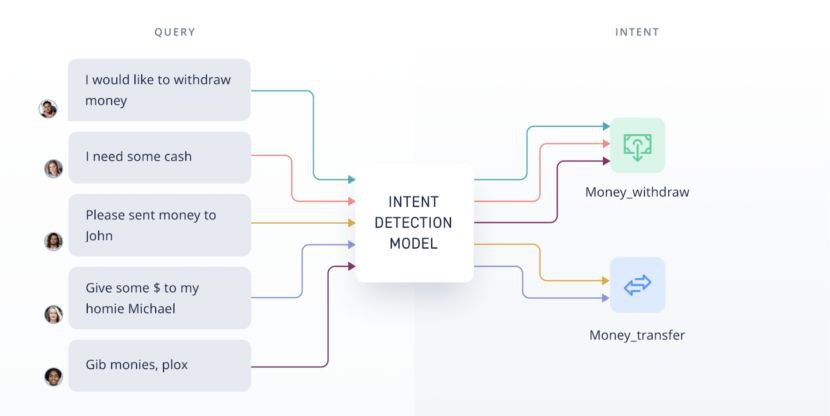



Будем работать с [данными](https://www.kaggle.com/datasets/constantinwerner/qa-intents-dataset-university-domain), которые собраны Новосибирским Государственным Университетом для своего QA-чатбота. Выбор в большой степени обусловлен именно "студенческим доменом". Описание гласит, что датасет содержит 142 интента (класса) и порядка 50-220 фраз на русском языке для каждого.

   0. Проведите небольшую аналитику имеющихся данных. Какой размер датасета? Сколько в среднем у нас имеется примеров на класс?  Что можно сказать насчет длины текстов, с которыми придется работать? С какими запросами приходится иметь дело?

   1. Для начала обучите какую-нибудь модель на основе архитектуры трансформер (например BERT-based модель для русского языка) целиком на исходном датасете. Не забудьте про валидацию. Измерьте качество на тестовой выборке. В качестве целевой метрики используйте точность.

   2. Далее попробуем имитировать следующий сетап. Предположим, что сначала у нас имеется 122 класса, к которым в течение времени планируется добавить еще 20 (а потом может быть еще и еще). Выделите начальные 122 класса и обучите какую-нибудь модель на них. Посчитайте точность на тесте. Теперь, когда нам потребуется добавить новые интенты, нам бы не хотелось обучать модель заново, так как это может занять много времени, делать это придется довольно часто, а научиться поддерживать новые сценарии хотелось бы быстро. Мы поступим следующим образом:
       * Будем обучать только слой для классификации. При добавлении новых классов к нему добавляются лишь новые случайно инициализированные строки(столбцы), большой трансформер при этом остается замороженным.
       * Для еще большего ускорения процесса дообучения данные, которые соответствуют "первым" 122 классам можно предварительно пропустить через трансформер, а полученные эмбеддинги сохранить на диск. Таким образом, при появлении новых интентов и данных к ним, через замороженный трансформер потребуется прогнать лишь новые тексты.
       * Проведите процесс дообучения на данных, соответствующим всем 142 классам, с учетом вышеизложенных предложений.
    
4. Попробуйте поэкспериментировать с разными головами для классификации (линейный слой, двухслойный MLP) и пуллингами (`[CLS]`, Mean-pooling).

5. Сравните результаты с точки зрения значения целевой метрики, а также эффективности по времени обучения и дообучения для разных подходов. Какие плюсы и минусы описанного метода? Какие улучшения вы можете предложить? Попробуйте найти, например, релевантные статьи или блог-посты.

In [ ]:
WORK_FOLDER = 'drive/MyDrive/ML/NLP_BHW'
DEVICE_NUM = 0
DEVICE = f"cuda:{DEVICE_NUM}" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
EPOCHS=10
NUM_CLASSES_TOTAL=142

In [ ]:
train = pd.read_table(f'{WORK_FOLDER}/dataset_train.tsv')
test = pd.read_table(f'{WORK_FOLDER}/dataset_test.tsv')
train.head()

,мне нужна справка,statement_general
0,оформить справку,statement_general
1,взять справку,statement_general
2,справку как получить,statement_general
3,справку ммф где получаться,statement_general
4,справка как получить,statement_general


In [ ]:
train.columns = ['text', 'statement']
test.columns = ['text', 'statement']

### *0. Аналитика*

In [ ]:
dataset_size = len(train)

avg_examples_per_class = dataset_size / 142

train['text_length'] = train['text'].apply(lambda x: len(x))
mean_text_length = train['text_length'].mean()
median_text_length = train['text_length'].median()

print(f"Размер датасета: {dataset_size}")
print(f"Среднее количество примеров на класс: {avg_examples_per_class:.2f}")
print(f"Средняя длина текста: {mean_text_length:.2f}")
print(f"Медианная длина текста: {median_text_length:.2f}")


# Вывод примеров запросов для первых 5 интентов
intent_list = train['statement'].unique()[:5]
for intent in intent_list:
    print(f"\nПримеры запросов для интента {intent}:")
    example_queries = train[train['statement'] == intent]['text'].sample(5)
    for query in example_queries:
        print(f"- {query}")

Размер датасета: 13229
Среднее количество примеров на класс: 93.16
Средняя длина текста: 29.88
Медианная длина текста: 28.00

Примеры запросов для интента statement_general:
- справку оформить
- справку надо мне оформить
- справку оформлять
- мне нужно оформить и получить справку
- оформлять справку

Примеры запросов для интента conform:
- получить справка о обучении
- справка студента фия оформлять
- как мне заказать справка обучающегося
- оформить справка обучающегося
- оформлять справка о обучении

Примеры запросов для интента smalltalk_creator:
- где есть созидатель
- отец расположен где
- разработчик распологается где
- где есть автор
- находится разработчик

Примеры запросов для интента smalltalk_bye:
- Всего хорошего
- Пока, свяжемся позже!
- Мы отлично поболтали
- покеда
- Ладно до завтра

Примеры запросов для интента dorm_price:
- находится стоимость общежития
- находится плата за общежитие
- цена общежития расположен где
- цена общежития распологается где
- плата за общежитие

In [ ]:
del train['text_length']

*Посмотрим на распределение классов*

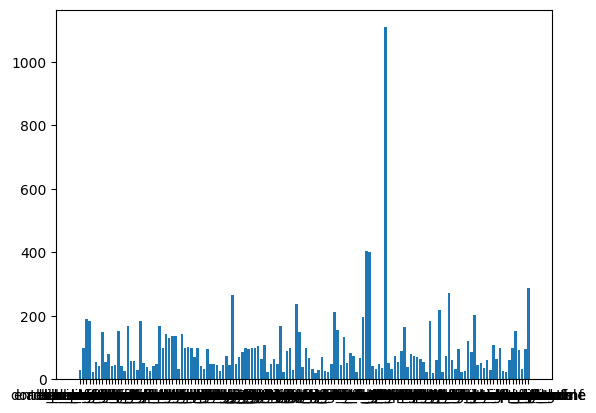

In [ ]:
group = train.groupby(['statement'])
plt.bar(group.count().index, group.count().iloc[:, 0].tolist());

In [ ]:
print(f"Самый частый запрос(statement): {group.count().index[np.argmax(group.count().iloc[:, 0].tolist())]}")

Самый частый запрос(statement): sched_teacher


In [ ]:
train[train.statement == 'sched_teacher'].head()

,text,statement
11141,расписание занятий Дорошкин А.А.,sched_teacher
11142,расписание преподавателя Толкачева Е.М.,sched_teacher
11143,где сейчас Идова Г.В.,sched_teacher
11144,где сейчас Чесноков А.А.,sched_teacher
11145,расписание преподавателя Новиков Д.А.,sched_teacher


*Это запрос расписания учителя. Изветсный мне метод балансирования классов - овер-сэмплинг плохо тут подойдет, так как классов очень много, и датасет раздуется в 10ки раз. Посмотрим, какой скор будет базовой модели, может придется урезать этот самый частый класс*

### *1. Базовая модель*

In [ ]:
encoder = LabelEncoder()
train['statement'] = encoder.fit_transform(train['statement'])

In [ ]:
train, validation = train_test_split(train, random_state=42)

*В этом задании попробую дргугую предобученную модель - rubert-base-cased-conversational, так как у нас стиль текстов как раз неформальный, ну и просто ради интереса, так как я везде брала стандартную rubert-base-cased*

In [ ]:
model_name = "DeepPavlov/rubert-base-cased-conversational"
tokenizer = AutoTokenizer.from_pretrained(model_name)
clear_output()

In [ ]:
def create_torch_dataset(dataset):
    tokenized = tokenizer(
    dataset["text"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt"
    )
    input_ids, masks = (
        tokenized["input_ids"],
        tokenized["attention_mask"],
    )
    labels = torch.tensor(dataset["statement"].tolist()).unsqueeze(-1)
    return TensorDataset(input_ids, masks, labels)

In [ ]:
train_dataset = create_torch_dataset(train)
val_dataset = create_torch_dataset(validation)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
base_model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels = NUM_CLASSES_TOTAL,
    output_attentions = False,
    output_hidden_states = False
)

base_model.to(DEVICE)
clear_output()

In [ ]:
class MyDataCollator:
    def __call__(self, batch):
        return {
            "input_ids": torch.stack([t[0] for t in batch]),
            "attention_mask": torch.stack([t[1] for t in batch]),
            "labels": torch.stack([t[2] for t in batch]),
        }


def custom_compute_metrics(preds):
    y_true = preds.label_ids
    y_pred = preds.predictions.logits.argmax(-1)
    return {"Accuracy": accuracy_score(y_true, y_pred)}


class CustomTrainer(Trainer):
    num_labels = NUM_CLASSES_TOTAL

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.logits
        labels_one_hot = F.one_hot(inputs["labels"], num_classes=model.num_labels).view(
            -1, model.num_labels
        )
        bse_loss = BCEWithLogitsLoss()
        loss = bse_loss(logits, labels_one_hot.float())
        if return_outputs:
            return (loss, {'logits': outputs, 'loss': loss})
        return loss


training_args = TrainingArguments(
    output_dir=f"{WORK_FOLDER}/Runs",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    logging_dir=f"{WORK_FOLDER}/Runs",
    remove_unused_columns=False,
    label_names=["labels"],
    include_inputs_for_metrics=True,
    evaluation_strategy="steps",
    eval_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="Accuracy",
)

trainer = CustomTrainer(
    model=base_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=MyDataCollator(),
    compute_metrics=custom_compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.002100,0.002336,0.938029
1000,0.002300,0.001873,0.948307
1500,0.001400,0.001620,0.951632
2000,0.001300,0.001456,0.952237
2500,0.001100,0.001425,0.951935
3000,0.001100,0.001404,0.952237
3500,0.001200,0.001490,0.948912
4000,0.001100,0.001414,0.951632
4500,0.001000,0.001395,0.951632
5000,0.001000,0.001381,0.950423


TrainOutput(global_step=6210, training_loss=0.0012924608089113774, metrics={'train_runtime': 971.3625, 'train_samples_per_second': 102.135, 'train_steps_per_second': 6.393, 'total_flos': 1071986822663400.0, 'train_loss': 0.0012924608089113774, 'epoch': 10.0})

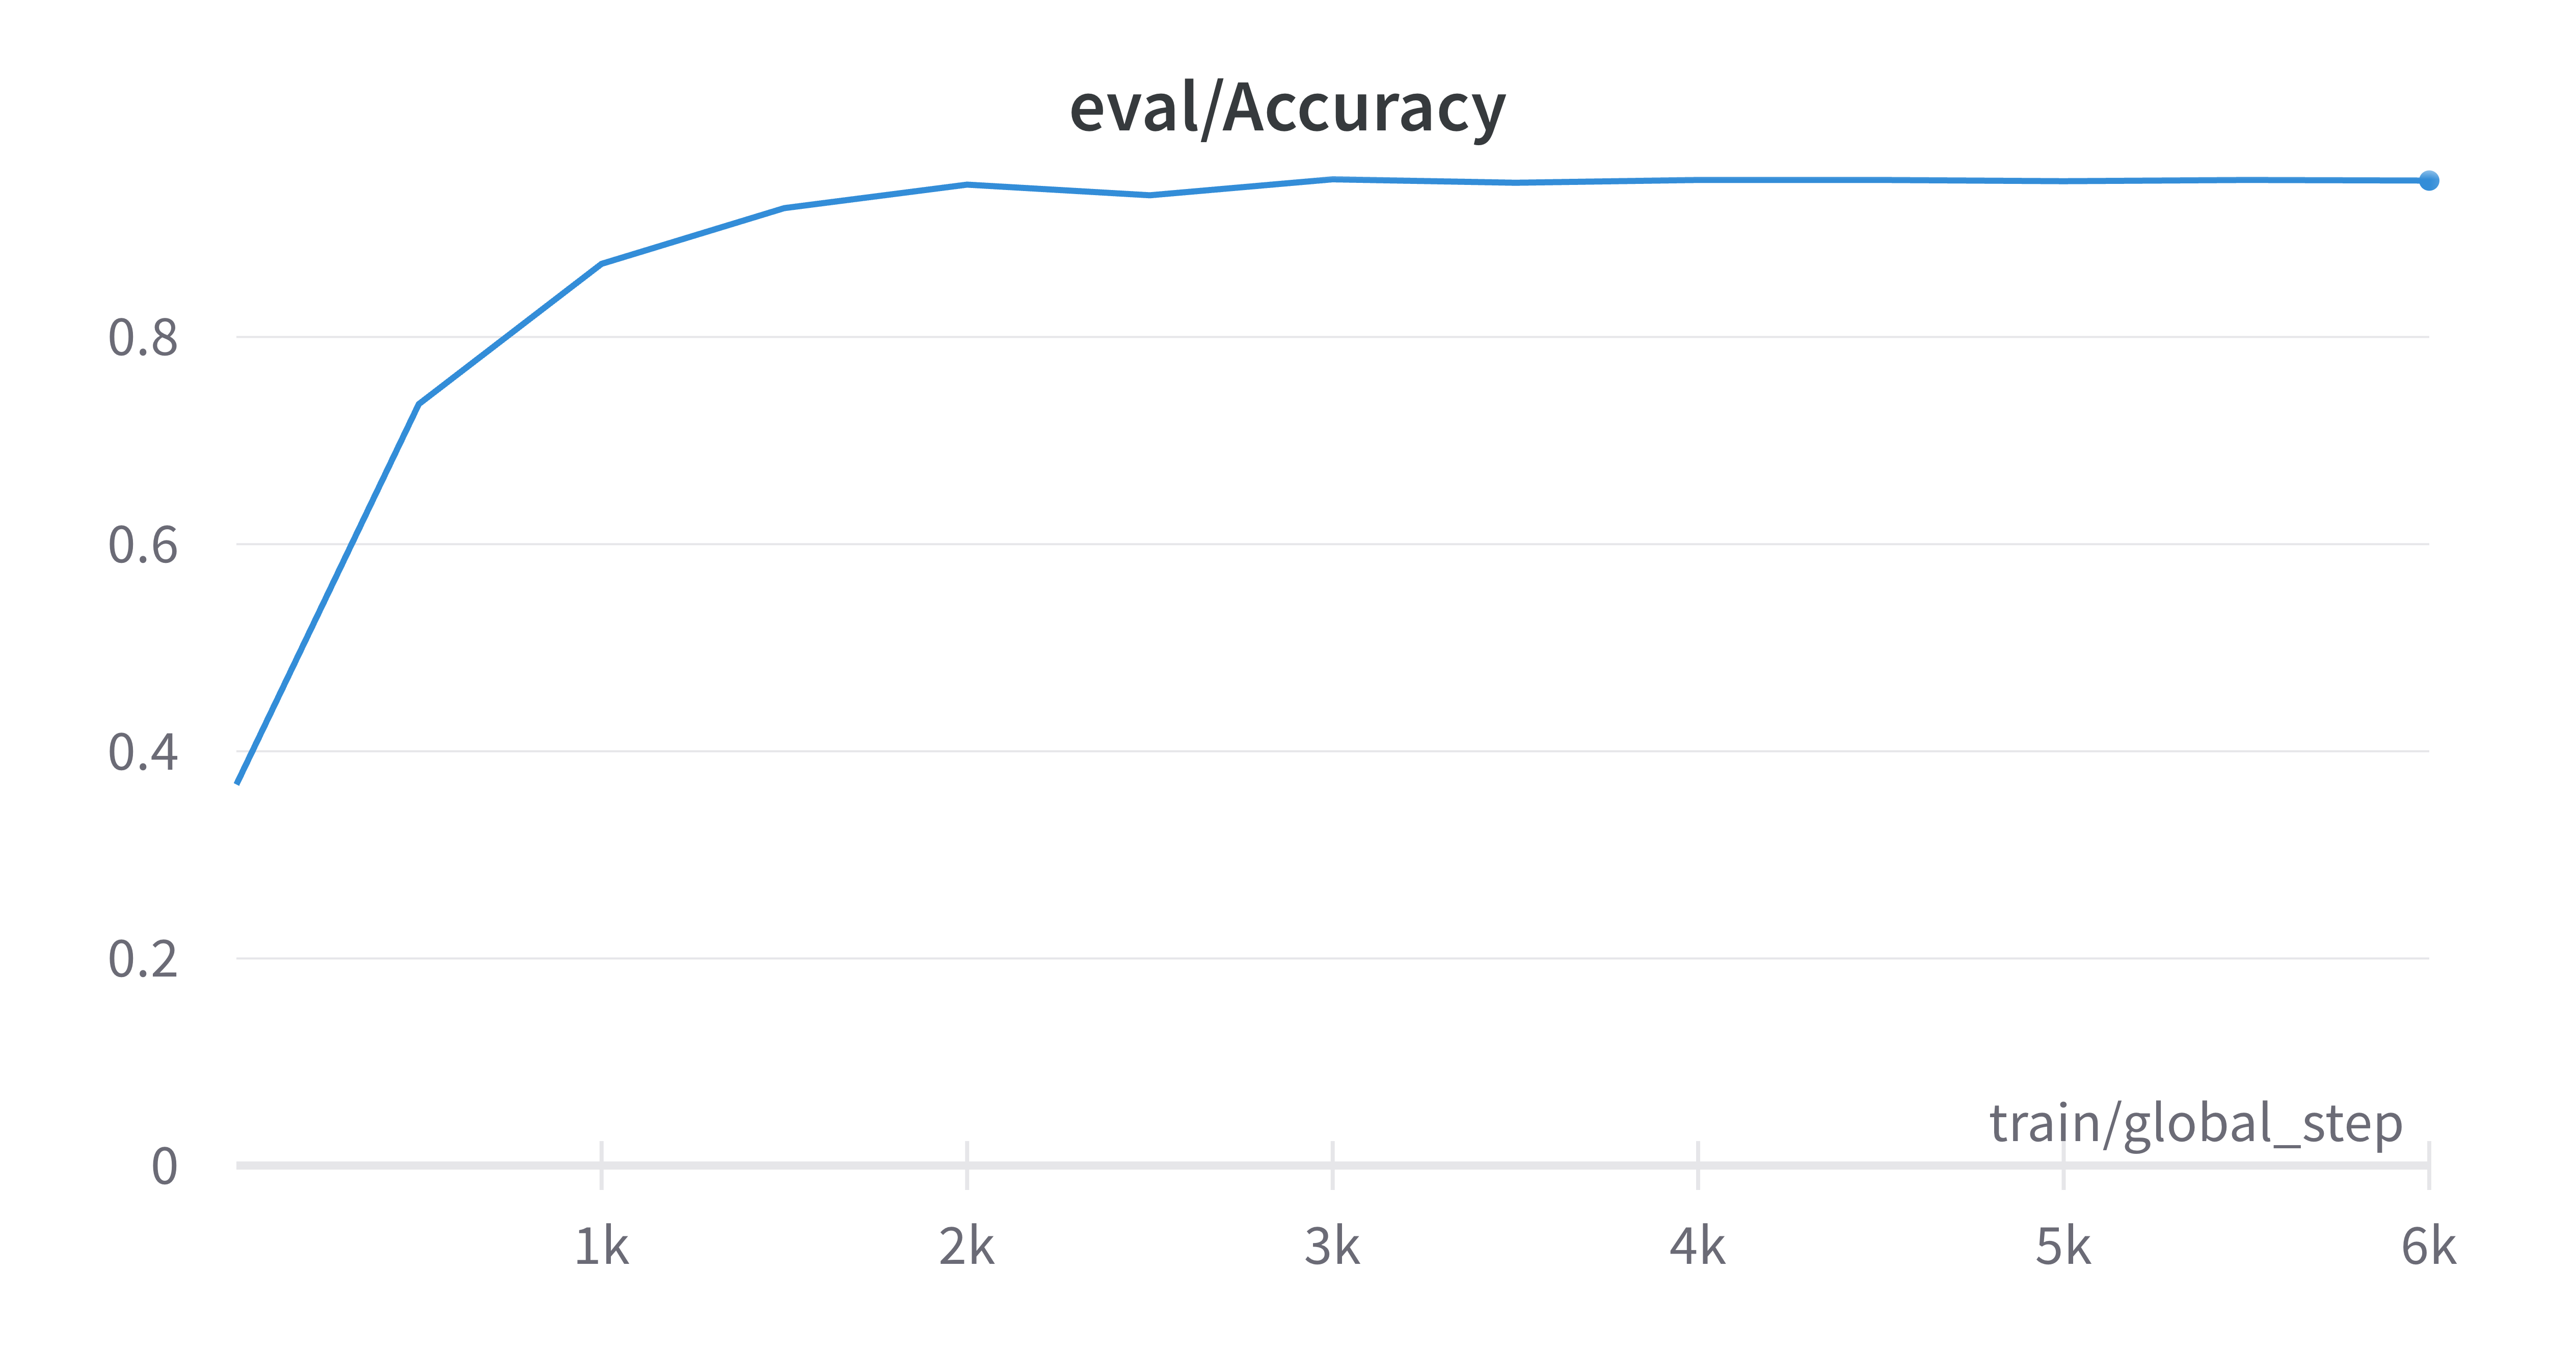

*Как обычно, базовая модель уже достаточно точна*

In [ ]:
test['statement'] = encoder.transform(test['statement'])
test_dataset = create_torch_dataset(test)

In [ ]:
def inference(model, test_dataset, logits=True):
    predictions = []
    with torch.no_grad():
        outputs = model(
            test_dataset.tensors[0].to(DEVICE),
            test_dataset.tensors[1].to(DEVICE),
        )
        if not logits:
            predictions = outputs.argmax(-1)
        else:
            predictions = outputs.logits.argmax(-1)
    return predictions

def test_accuracy(preds, cpu=True):
    if not cpu:
        return accuracy_score(preds, test['statement'])
    else:
        return accuracy_score(preds.cpu(), test['statement'])

In [ ]:
predictions = inference(base_model, test_dataset)
print(f"Accuracy на тесте: {test_accuracy(predictions)}")

Accuracy на тесте: 0.9546485260770975


In [ ]:
torch.cuda.empty_cache()

*Кайф. Модель хорошо справляется с несбалансированными класами*

### *2. Последовательное обучение*

In [ ]:
NUM_CLASSES_SUB = 122

In [ ]:
train_sub = train[train['statement'] <= 121]
validation_sub = validation[validation['statement'] <= 121]

train_remain = train[train['statement'] > 121]
validation_remain = validation[validation['statement'] > 121]

In [ ]:
train_dataset_sub = create_torch_dataset(train_sub)
val_dataset_sub = create_torch_dataset(validation_sub)

train_dataset_remain = create_torch_dataset(train_remain)
val_dataset_remain = create_torch_dataset(validation_remain)

In [ ]:
class CustomTrainer(Trainer):
    num_labels = NUM_CLASSES_SUB

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.logits
        labels_one_hot = F.one_hot(inputs["labels"], num_classes=model.num_labels).view(
            -1, model.num_labels
        )
        bse_loss = BCEWithLogitsLoss()
        loss = bse_loss(logits, labels_one_hot.float())
        if return_outputs:
            return (loss, {'logits': outputs, 'loss': loss})
        return loss

model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels = NUM_CLASSES_SUB,
    output_attentions = False,
    output_hidden_states = False
)

model.to(DEVICE)
clear_output()

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_sub,
    eval_dataset=val_dataset_sub,
    data_collator=MyDataCollator(),
    compute_metrics=custom_compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Currently logged in as: lisabeth-shevtsova (liza-i-pivko). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
500,0.088700,0.044758,0.096424
1000,0.043600,0.040613,0.134642
1500,0.035800,0.029528,0.597125
2000,0.023800,0.018624,0.829243
2500,0.015300,0.012452,0.907784
3000,0.010800,0.009246,0.938289
3500,0.008100,0.007359,0.940042
4000,0.006600,0.006213,0.944600
4500,0.005700,0.005530,0.945652
5000,0.005100,0.005175,0.944600


TrainOutput(global_step=5390, training_loss=0.022946921969610155, metrics={'train_runtime': 888.2402, 'train_samples_per_second': 96.978, 'train_steps_per_second': 6.068, 'total_flos': 930595543592400.0, 'train_loss': 0.022946921969610155, 'epoch': 10.0})

In [ ]:
trainer.save_pretrained(f'{WORK_FOLDER}/model_122_classes')

In [ ]:
predictions_sub = inference(model, test_dataset)
print(f"Accuracy на тесте: {test_accuracy(predictions_sub)}")

Accuracy на тесте: 0.8276643990929705


*Метрика ожидаемо снизилась, так как предсказываем все классы, а обучали только на 122*

*Fine-tuning модели для добавления оставшихся 20 классов: замораживаем все слои и сверху добавляем только 1 обучаемый классификатор на полное количество классов*

In [ ]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier = torch.nn.Linear(model.config.hidden_size, NUM_CLASSES_TOTAL)
model.num_labels = NUM_CLASSES_TOTAL

*Обучаем, при этом нужно сильно увеличить кол-во эпох так как обучается только 1 слой*

In [ ]:
training_args.num_train_epochs = 100

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_remain,
    eval_dataset=val_dataset_remain,
    data_collator=MyDataCollator(),
    compute_metrics=custom_compute_metrics
)

trainer.train()

In [ ]:
predictions_fine_tuned = trainer.predict(test_dataset).label_ids.reshape(-1)
print(f"Accuracy на тесте: {test_accuracy(predictions_fine_tuned, cpu=False)}")

Accuracy на тесте: 0.828898272947


### *3. 2 линейных слоя + mean pooling*

In [ ]:
class MeanPooling(nn.Module):
    def forward(self, hidden_states, attention_mask):
        mask = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
        sum_hidden_states = torch.sum(hidden_states * mask, dim=1)
        sum_mask = torch.clamp(mask.sum(1), min=1e-9)
        return sum_hidden_states / sum_mask

class TwoLayerMLPClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes, dropout_rate=0.1):
        super().__init__()
        self.layer1 = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

class CustomBertForTokenClassification(BertForSequenceClassification):
    def __init__(self, num_labels, config):
        super().__init__(config)
        self.num_labels = num_labels
        self.pooling = MeanPooling()
        self.bert = model.base_model # предобученная на 122 класса
        self.classifier = TwoLayerMLPClassifier(self.bert.config.hidden_size, self.num_labels)

    def forward(self, input_ids, attention_mask, **kwargs):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        pooled_output = self.pooling(hidden_states, attention_mask)
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
config = BertConfig.from_json_file(f'{WORK_FOLDER}/model_122_classes/config.json')
model_last = CustomBertForTokenClassification(NUM_CLASSES_TOTAL, config)
model_last.to(DEVICE)

clear_output()

In [ ]:
for param in model_last.base_model.parameters():
    param.requires_grad = False

In [ ]:
training_args.num_train_epochs = 100

def custom_compute_metrics(preds):
    y_true = preds.label_ids
    y_pred = preds.predictions.argmax(-1)
    return {"Accuracy": accuracy_score(y_true, y_pred)}

class CustomTrainer(Trainer):
    num_labels = NUM_CLASSES_SUB

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs
        labels_one_hot = F.one_hot(inputs["labels"], num_classes=model.num_labels).view(
            -1, model.num_labels
        )
        bse_loss = BCEWithLogitsLoss()
        loss = bse_loss(logits, labels_one_hot.float())
        if return_outputs:
            return (loss, {'logits': outputs, 'loss': loss})
        return loss

trainer = CustomTrainer(
    model=model_last,
    args=training_args,
    train_dataset=train_dataset_remain,
    eval_dataset=val_dataset_remain,
    data_collator=MyDataCollator(),
    compute_metrics=custom_compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.011700,0.006586,0.932018
1000,0.005600,0.003860,0.964912
1500,0.003600,0.002745,0.973684
2000,0.002700,0.002177,0.975877
2500,0.002100,0.001781,0.978070
3000,0.001800,0.001553,0.980263
3500,0.001500,0.001370,0.982456
4000,0.001400,0.001284,0.984649
4500,0.001200,0.001153,0.982456
5000,0.001100,0.001096,0.986842


TrainOutput(global_step=8200, training_loss=0.002369396959136172, metrics={'train_runtime': 379.8822, 'train_samples_per_second': 344.054, 'train_steps_per_second': 21.586, 'total_flos': 1421969488052400.0, 'train_loss': 0.002369396959136172, 'epoch': 100.0})

In [ ]:
predictions_fine_tuned = trainer.predict(test_dataset).label_ids.reshape(-1)
print(f"Accuracy на тесте: {test_accuracy(predictions_fine_tuned, cpu=False)}")

Accuracy на тесте: 1.0


### *4. Сравнение моделей / выводы*

*Модель обученная на всех классах ожидаемо дает хороший скор. Однако она наименее эффективная с точки зрения времени обучения. Модели с только обучаемым слоем классификации конечно же дообучаются в разы быстрее, это видно из лога трейнера - например модель на 122 класса обучалась 10 эпох 14 минут, а дообучение на 142 класса обоих классификаторов 100 эпох - в районе 5 минут.*

*Классификатор с 2 лин слоями и mean pooling-ом показал себя сильно лучше чем один простой линейный слой, и даже лучше чем исходная модель на все классы. Тоже ожидаемо, так как такой классификатор сильнее чем 1 линейный слой у обоих других моделей*